## Import required libraries

In [67]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Check if GPU is available

In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
print("Devices Available: ", tf.config.list_physical_devices())

Devices Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Define constants

In [32]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

## Reading and forming a tensorflow dataset

In [6]:
dataset =  image_dataset_from_directory(
    'Dataset/Potatoes',
    shuffle = True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


## Extracting class labels

In [7]:
classes = dataset.class_names
classes

['Early_blight', 'Healthy', 'Late_blight']

## Data Exploration

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 0 0 2 0 0 0 0 2 2 2 0 0 2 0 0 2 2 2 0 0 2 2 0 0 0 2 0 0 0 2]


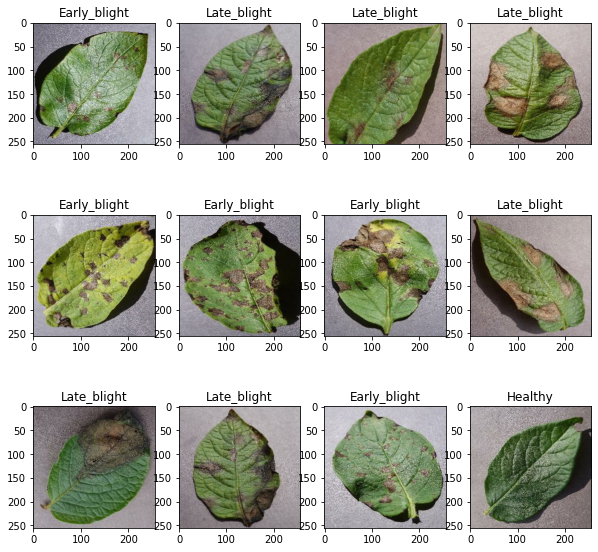

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.title(classes[label_batch[i].numpy()])
        plt.imshow(image_batch[i].numpy().astype('uint8'))

## Spliting data into training, validation and testing set

In [11]:
len(dataset)

68

In [19]:
TRAIN_SIZE = 0.8
len(dataset) * TRAIN_SIZE

54.400000000000006

In [20]:
train_dataset = dataset.take(54)
len(train_dataset)

54

In [14]:
TEST_SIZE = 0.1
len(dataset) * TEST_SIZE

6.800000000000001

In [21]:
val_dataset = dataset.skip(54).take(6)
len(val_dataset)

6

In [22]:
test_dataset = dataset.skip(60)
len(test_dataset)

8

In [23]:
def train_test_split(dataset, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_buffer_size = 10000):
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer_size, seed = 28)
        
    dataset_size = len(dataset)
    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * val_split)
    
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

In [24]:
train_dataset, val_dataset, test_datasete = train_test_split(dataset)

In [26]:
print('Train dataset size:', len(train_dataset), 
      'Validation dataset size:', len(val_dataset), 
      'Test dataset size:', len(test_dataset), 
     )

Train dataset size: 54 Validation dataset size: 6 Test dataset size: 8


## Optimize dataset by caching and prefetching

In [28]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Preprocessing layers for image

In [29]:
resize_rescale = Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1.0 / 255)
])

In [30]:
data_augmentation  = Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
])

## Model Creation

In [33]:
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    Conv2D(32, (3, 3), activation='relu', input_shape = INPUT_SHAPE),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, kernel_size = (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, kernel_size = (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, kernel_size = (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, kernel_size = (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(len(classes), activation='softmax'),
])

model.build(input_shape = INPUT_SHAPE)

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
dropout (Dropout)            (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)         

In [35]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=25)
mc = ModelCheckpoint('Models/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [42]:
%%time
history = model.fit(
    train_dataset,
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=(val_dataset),
    callbacks=[es, mc]
)

Epoch 1/100
54/54 [==============================] - 6s 100ms/step - loss: 0.0841 - accuracy: 0.9641 - val_loss: 0.2613 - val_accuracy: 0.9115

Epoch 00001: val_accuracy improved from -inf to 0.91146, saving model to Models\best_model.h5
Epoch 2/100
54/54 [==============================] - 5s 99ms/step - loss: 0.0550 - accuracy: 0.9792 - val_loss: 0.4215 - val_accuracy: 0.8854

Epoch 00002: val_accuracy did not improve from 0.91146
Epoch 3/100
54/54 [==============================] - 5s 99ms/step - loss: 0.0819 - accuracy: 0.9757 - val_loss: 0.3129 - val_accuracy: 0.8906

Epoch 00003: val_accuracy did not improve from 0.91146
Epoch 4/100
54/54 [==============================] - 5s 99ms/step - loss: 0.1019 - accuracy: 0.9676 - val_loss: 0.0821 - val_accuracy: 0.9844

Epoch 00004: val_accuracy improved from 0.91146 to 0.98438, saving model to Models\best_model.h5
Epoch 5/100
54/54 [==============================] - 5s 99ms/step - loss: 0.0509 - accuracy: 0.9855 - val_loss: 0.1359 - val_a

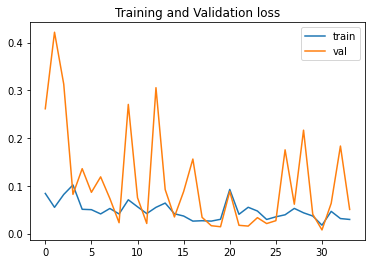

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

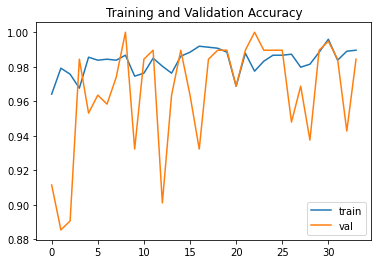

In [47]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [48]:
best_model = load_model('Models/best_model.h5')

In [49]:
model.evaluate(test_dataset)

8/8 [==============================] - 3s 74ms/step - loss: 0.0701 - accuracy: 0.9741


[0.07014887779951096, 0.9741379022598267]

In [50]:
best_model.evaluate(test_dataset)

8/8 [==============================] - 0s 40ms/step - loss: 0.0457 - accuracy: 0.9914


[0.045692574232816696, 0.9913793206214905]

Actual Label: Late_blight
Predicted Label: Late_blight
Best model Predicted Label: Late_blight


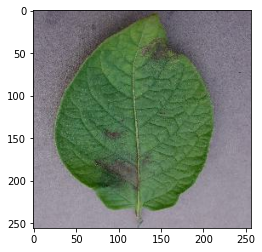

In [65]:
for batch_images, batch_labels in test_dataset.take(1):
    img = batch_images[0].numpy().astype('uint8')
    label = batch_labels[0].numpy()
    
    plt.imshow(img)
    print(f'Actual Label: {classes[label]}')
    prediction1 = model.predict(batch_images)
    prediction2 = best_model.predict(batch_images)
    print(f'Predicted Label: {classes[np.argmax(prediction1[0])]}')
    print(f'Best model Predicted Label: {classes[np.argmax(prediction2[0])]}')
    

In [79]:
actual_labels = []
predicted_labels = []
for batch_images, batch_labels in test_dataset:
    actual_labels.extend(batch_labels.numpy())
    predicted_labels.extend(np.argmax(best_model.predict(batch_images), axis=1))

In [81]:
print(classification_report(actual_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       108
           1       1.00      0.89      0.94        19
           2       0.99      1.00      1.00       105

    accuracy                           0.99       232
   macro avg       0.99      0.96      0.98       232
weighted avg       0.99      0.99      0.99       232



<AxesSubplot:>

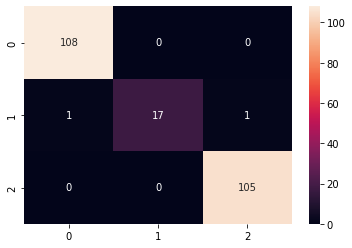

In [86]:
sns.heatmap(confusion_matrix(actual_labels, predicted_labels), annot=True, fmt='')

In [96]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

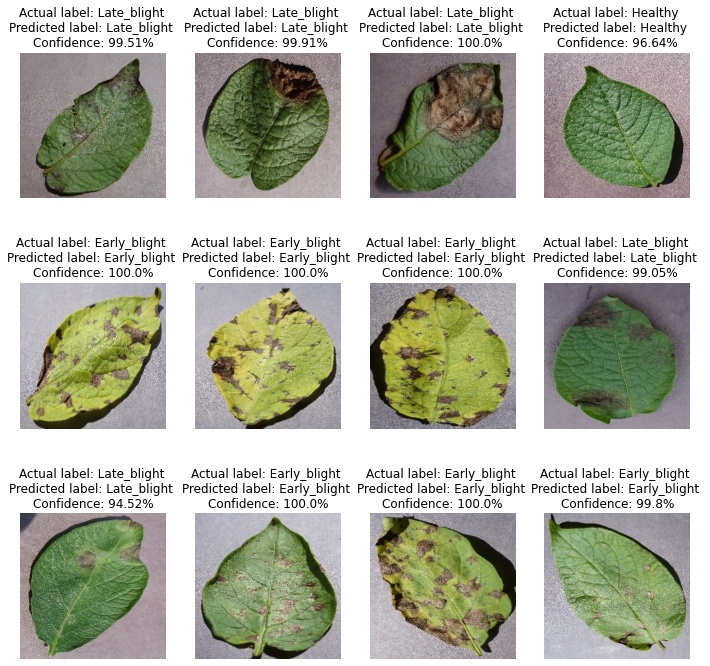

In [101]:
plt.figure(figsize = (12, 12))
for batch_images, batch_labels in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(batch_images[i].numpy().astype('uint8'))
        
        actual_label = classes[batch_labels[i]]
        predicted_label, confidence = predict(best_model, batch_images[i])
        
        plt.title(f'Actual label: {actual_label} \nPredicted label: {predicted_label} \nConfidence: {confidence}%')
        plt.axis('off')